In [2]:
from typing import List, Tuple, Dict, Any, Optional
from pandarallel import pandarallel
import os
import re
import sys
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
path_qasm_a = "../program_bank/v025/2025_02_07__19_47/0000001_qite_8c22b8.qasm"
path_qasm_b = "../program_bank/v025/2025_02_07__19_47/0000001_qite_59bd5b.qasm"

In [4]:
from qiskit.qasm2 import load, LEGACY_CUSTOM_INSTRUCTIONS

qc_a = load(path_qasm_a, custom_instructions=LEGACY_CUSTOM_INSTRUCTIONS)
qc_b = load(path_qasm_b, custom_instructions=LEGACY_CUSTOM_INSTRUCTIONS)
print("QASM - CIRCUIT A")
print(qc_a.draw())
print("QASM - CIRCUIT B")
print(qc_b.draw())

QASM - CIRCUIT A
                                                                           »
 q_0: ────────────────────────────■────────────────────────────────────────»
         ┌─────────────────┐      │                                        »
 q_1: ───┤ U3(0,-π/2,5π/8) ├──────┼────────────────────────────────────────»
         ├─────────────────┤      │       ┌───┐   ┌───────────────────┐    »
 q_2: ───┤ U3(0,-π/2,5π/8) ├──────┼───────┤ X ├───┤ U3(0,-π/2,13.744) ├────»
         └┬────────────────┤      │       └─┬─┘   └───────────────────┘    »
 q_3: ────┤ U3(π,-π/2,π/2) ├──────┼────■────┼──────────────────────────────»
      ┌───┴────────────────┴───┐  │    │    │                              »
 q_4: ┤ U3(3.0858,0.50108,π/2) ├──┼────┼────┼──────────────────────────────»
      └────────────────────────┘  │    │    │                              »
 q_5: ────────────────────────────┼────┼────┼──────────────────────────────»
        ┌────────────────────┐  ┌─┴─┐  │    │     ┌────────

In [5]:
from qiskit import transpile

qc_a_gateset = transpile(qc_a, basis_gates=['u1', 'u2', 'u3', 'cx'])
qc_b_gateset = transpile(qc_b, basis_gates=['u1', 'u2', 'u3', 'cx'])

print("GATESET - CIRCUIT A")
print(qc_a_gateset.draw())
print("GATESET - CIRCUIT B")
print(qc_b_gateset.draw())

GATESET - CIRCUIT A
global phase: 4.5744
                                                                           »
 q_0: ────────────────────────────■────────────────────────────────────────»
         ┌─────────────────┐      │                                        »
 q_1: ───┤ U3(0,-π/2,5π/8) ├──────┼────────────────────────────────────────»
         ├─────────────────┤      │       ┌───┐   ┌───────────────────┐    »
 q_2: ───┤ U3(0,-π/2,5π/8) ├──────┼───────┤ X ├───┤ U3(0,-π/2,13.744) ├────»
         └┬────────────────┤      │       └─┬─┘   └───────────────────┘    »
 q_3: ────┤ U3(π,-π/2,π/2) ├──────┼────■────┼──────────────────────────────»
      ┌───┴────────────────┴───┐  │    │    │                              »
 q_4: ┤ U3(3.0858,0.50108,π/2) ├──┼────┼────┼──────────────────────────────»
      └────────────────────────┘  │    │    │                              »
 q_5: ────────────────────────────┼────┼────┼──────────────────────────────»
        ┌────────────────────┐  ┌─┴

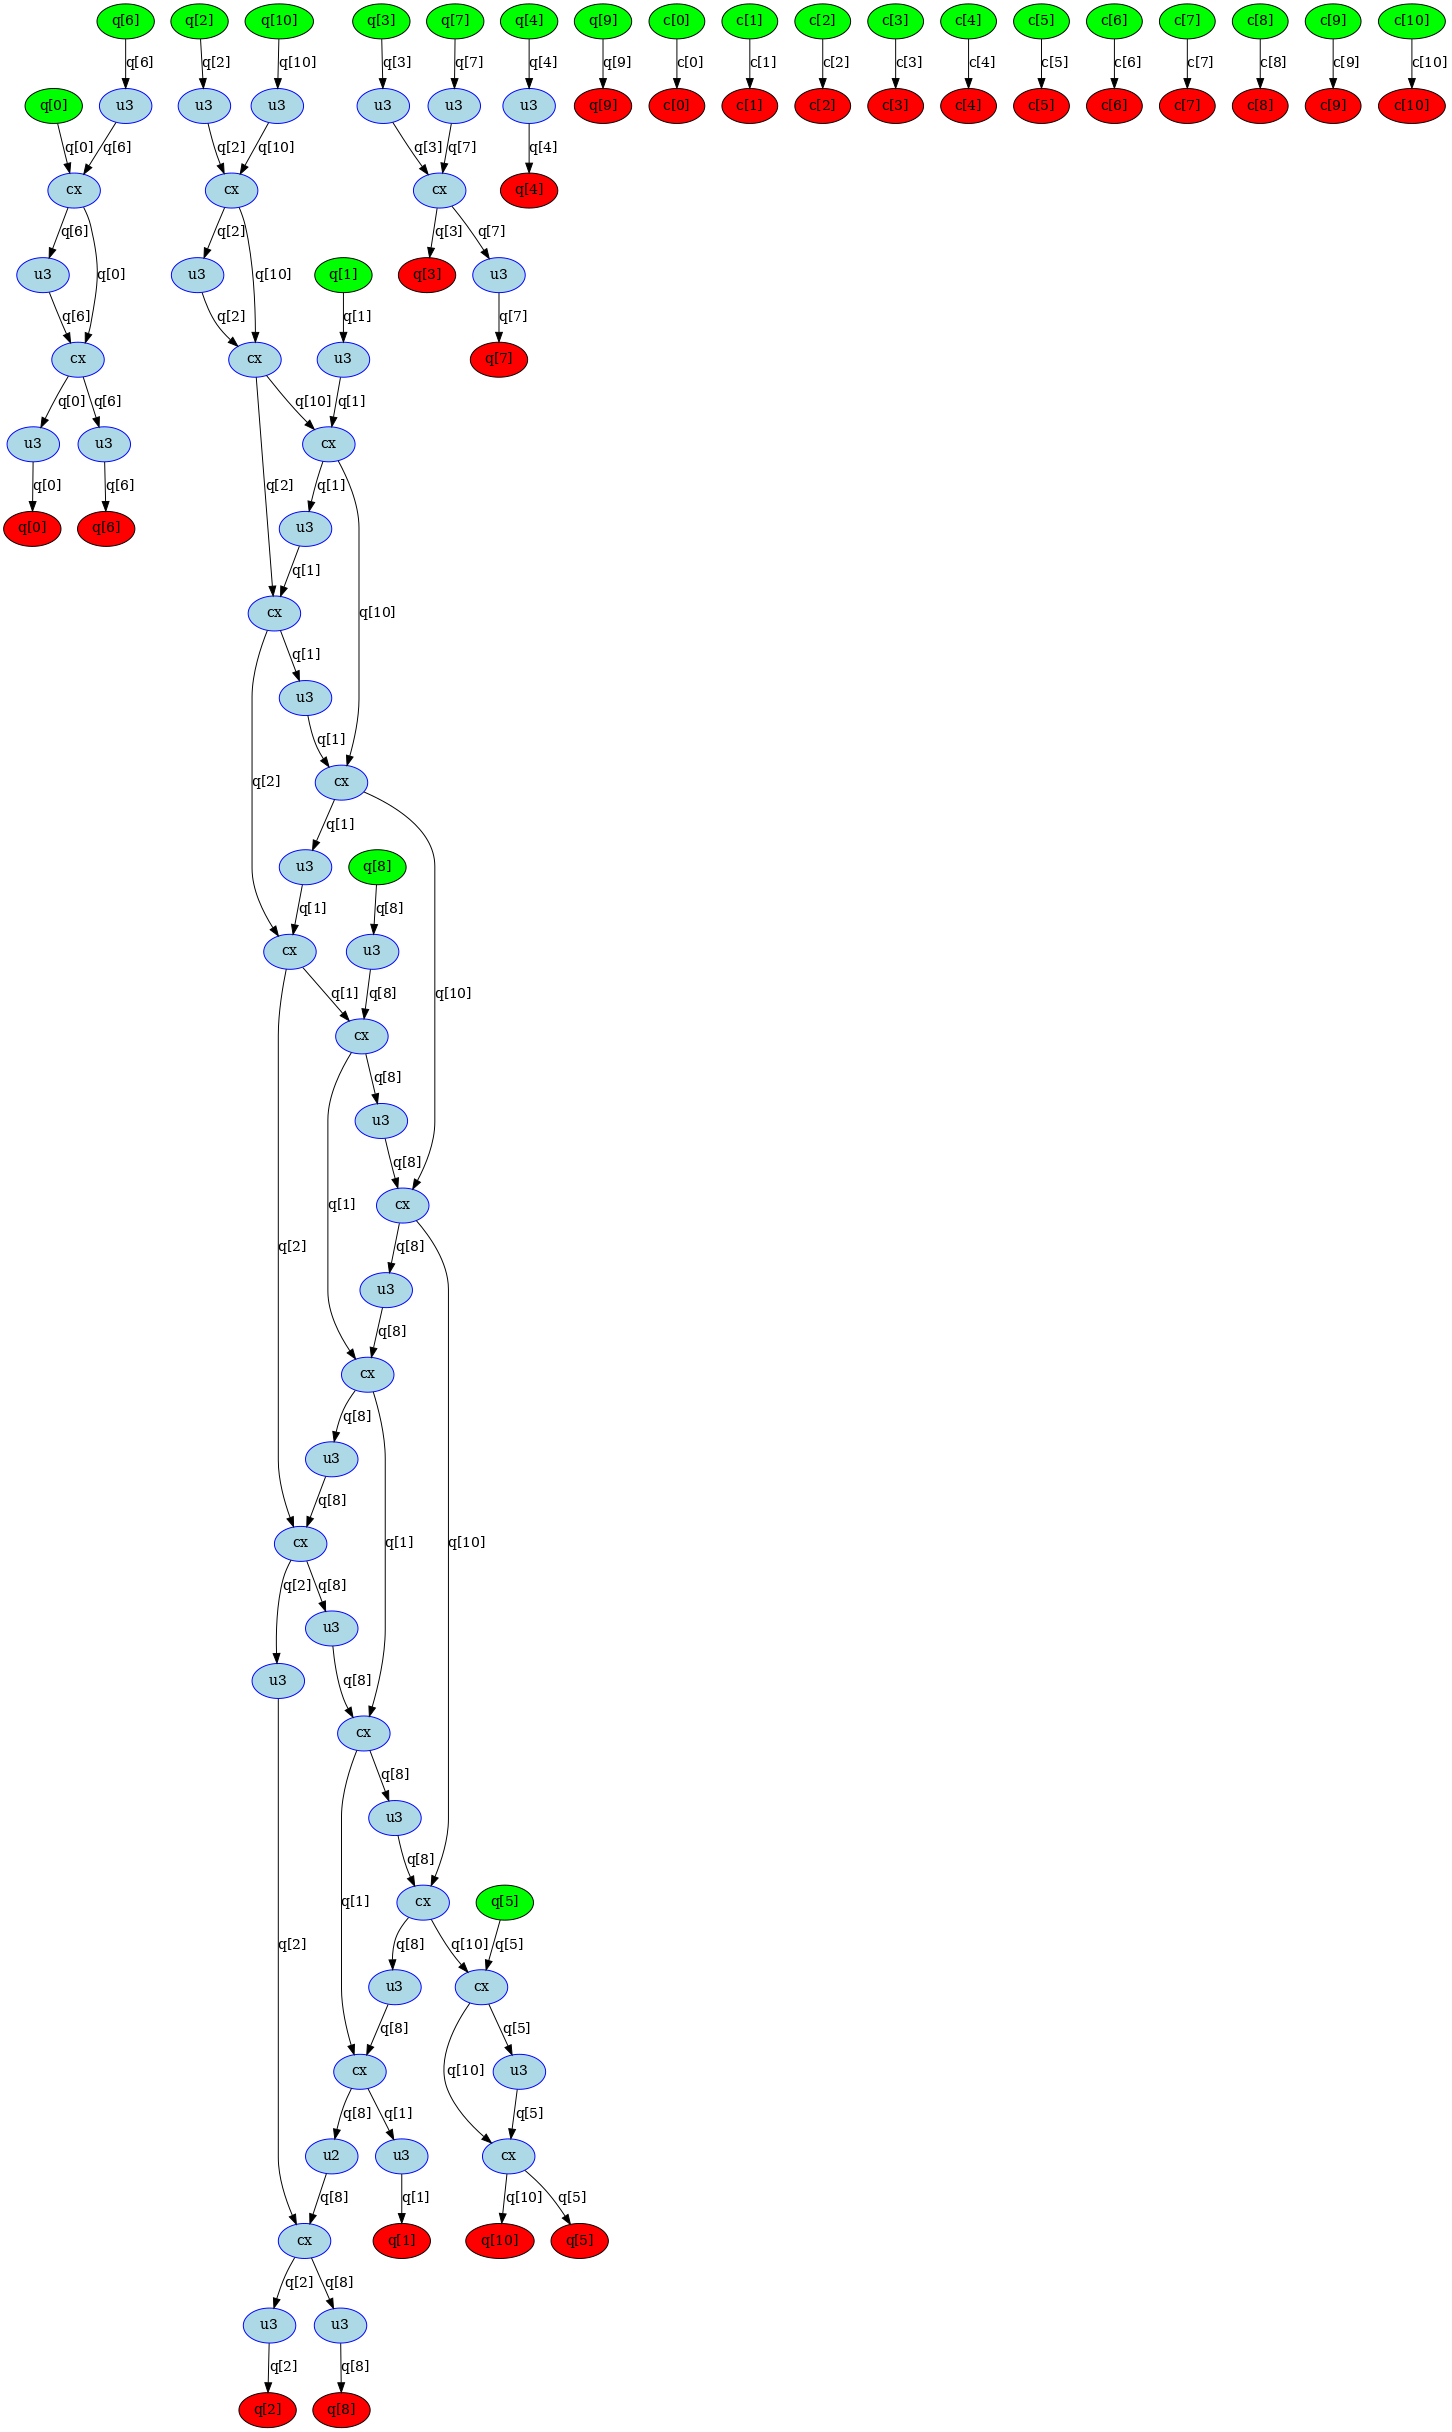

In [6]:
from qiskit.converters import (
    circuit_to_dag,
    dag_to_circuit,
)
from qiskit.visualization import dag_drawer

dag_a = circuit_to_dag(qc_a_gateset)
dag_drawer(dag_a)

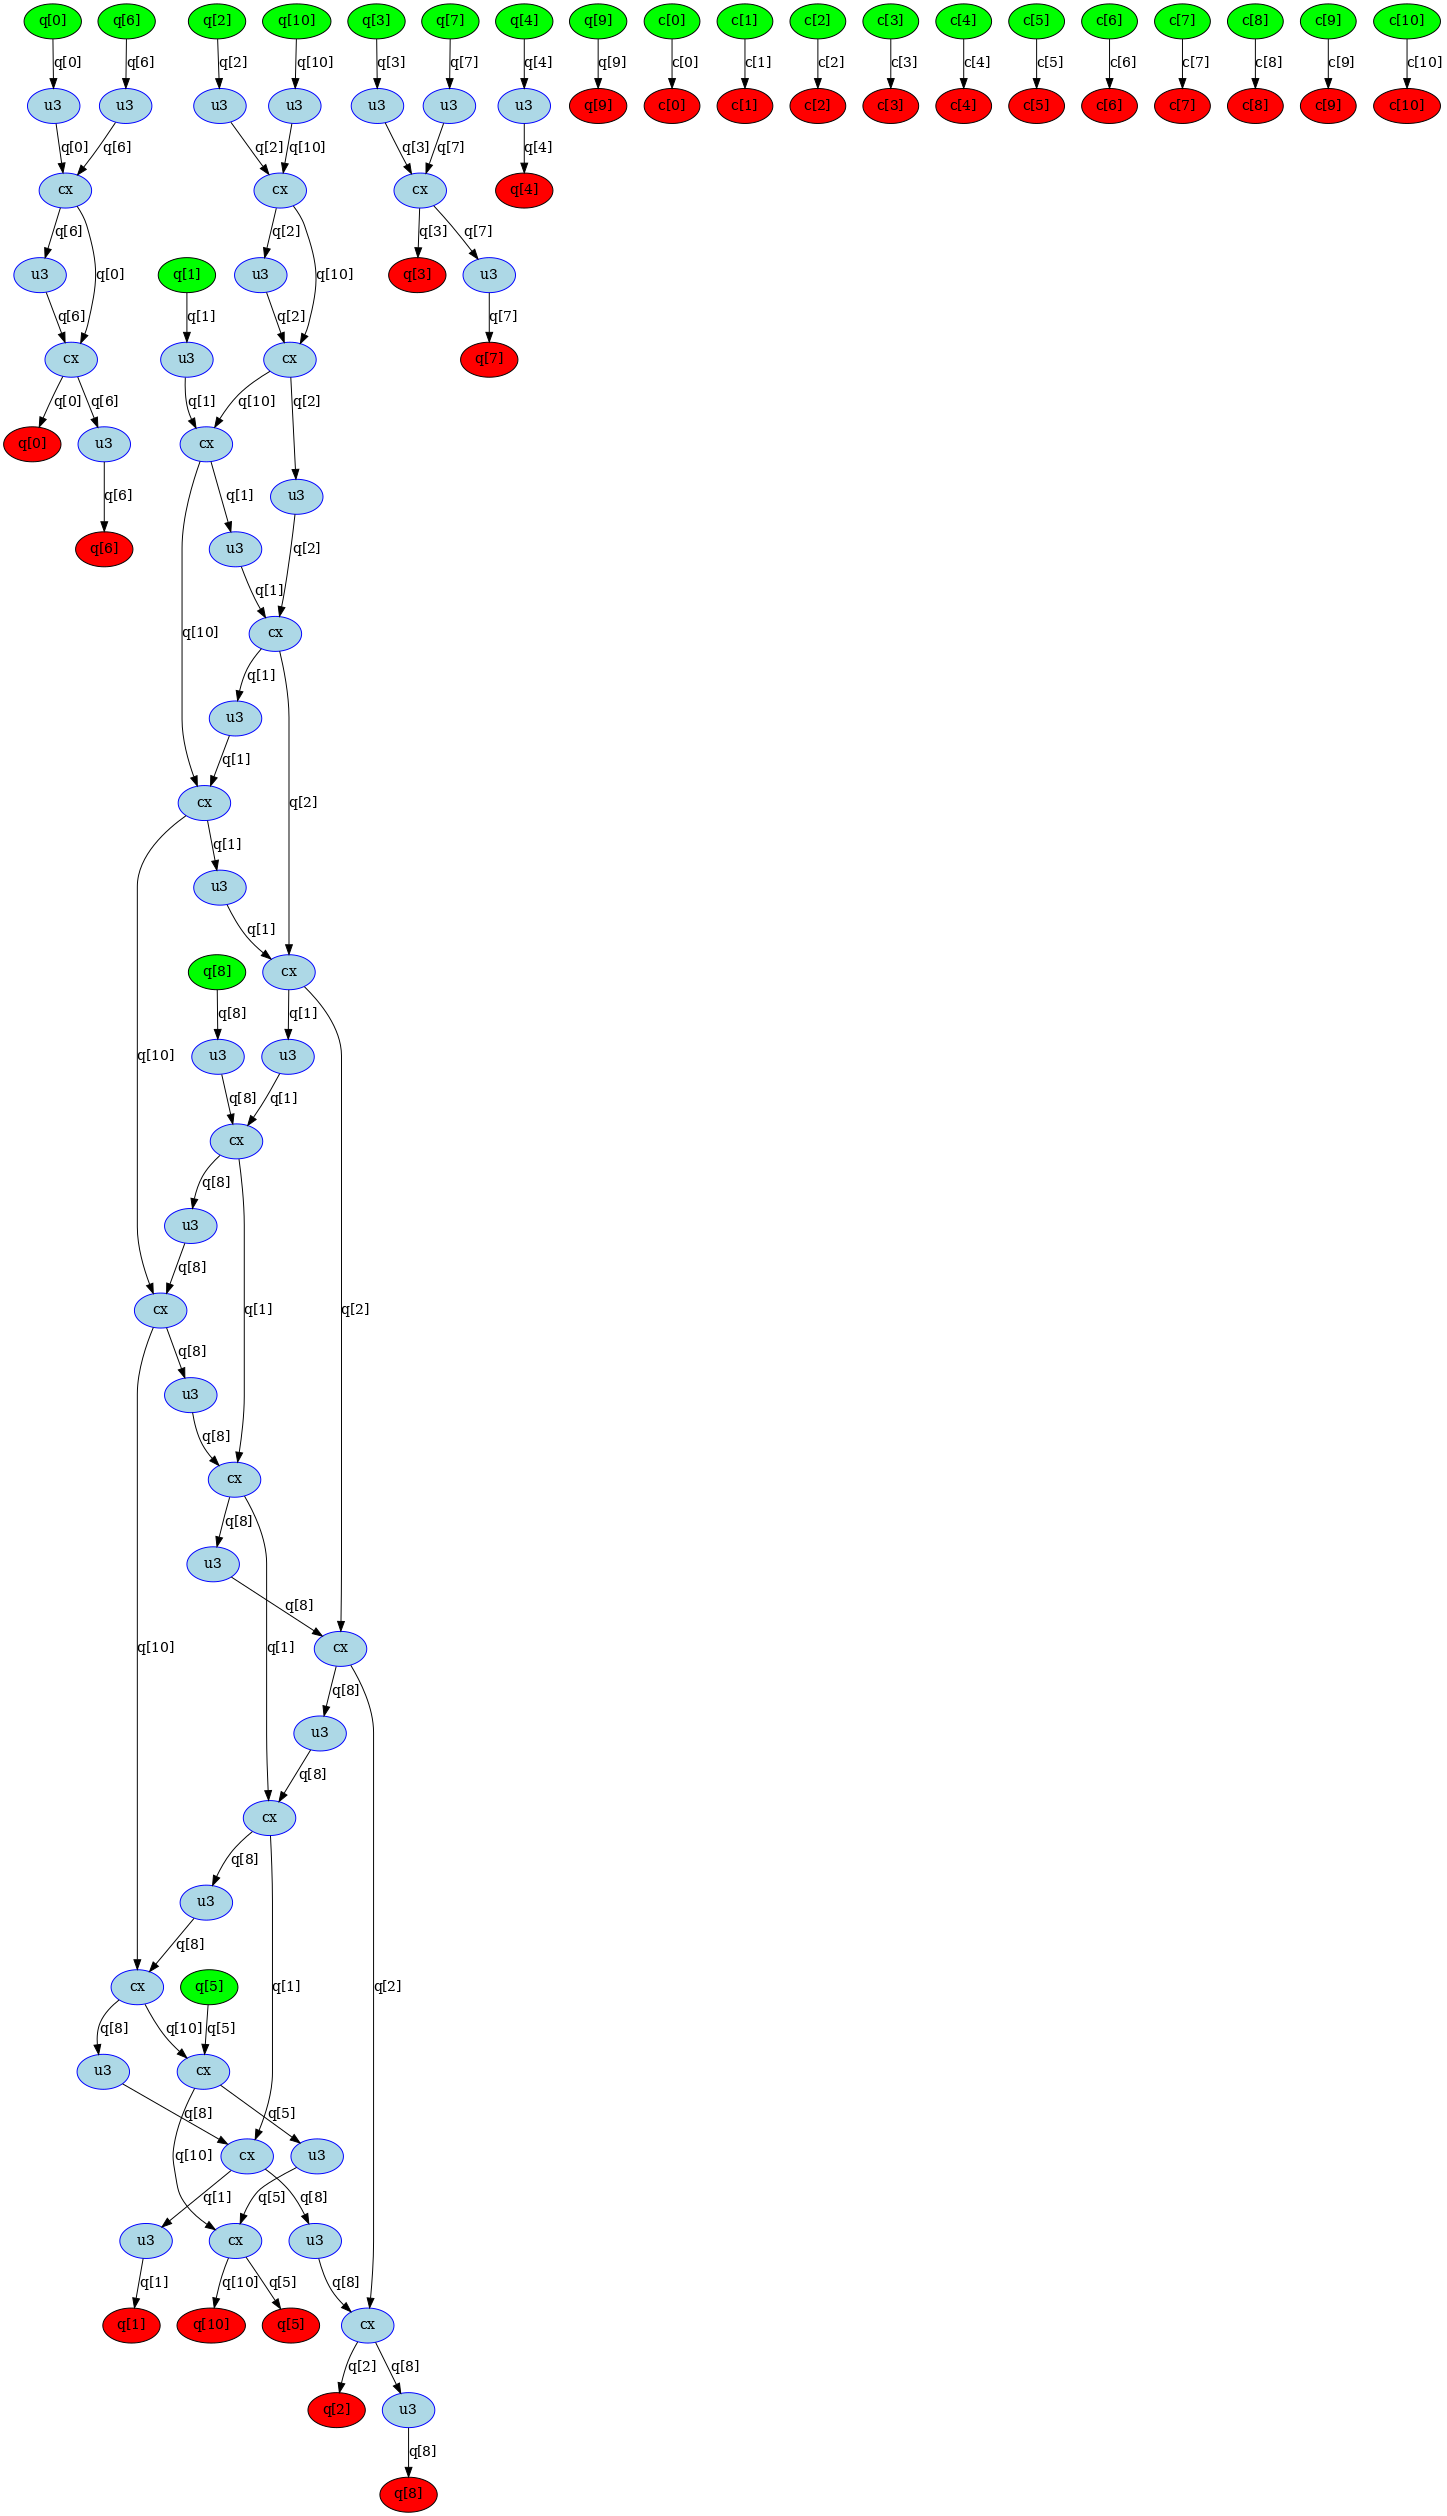

In [7]:
dag_b = circuit_to_dag(qc_b_gateset)
dag_drawer(dag_b)

In [8]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

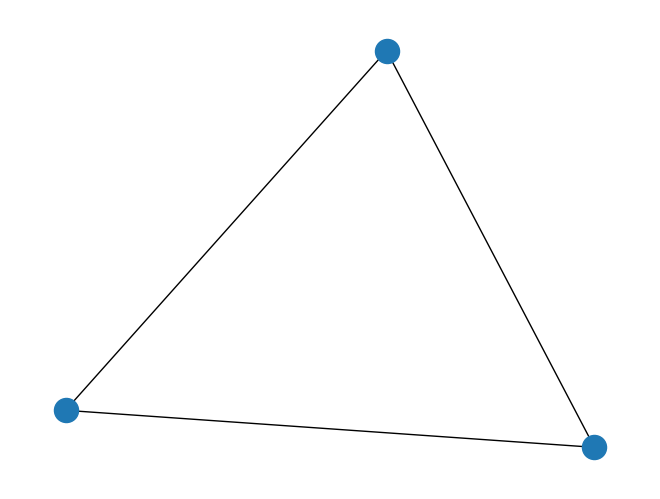

In [9]:
from rustworkx.visualization import mpl_draw

graph_toy = rx.PyGraph()
graph_toy.add_nodes_from([0, 1, 2])
graph_toy.add_edges_from(
    [(0, 1, "edge_0_1"),
     (1, 2, "edge_1_2"),
     (2, 0, "edge_2_0")])

mpl_draw(graph_toy)

In [19]:
def create_graph_from_dag(dag, debug=False):
    graph = rx.PyDiGraph()
    node_to_int = {node.__repr__(): i for i, node in enumerate(dag.nodes())}
    int_to_node = {i: node_name for node_name, i in node_to_int.items()}

    for node in dag.nodes():
        node_name = node.__repr__()
        node_id = node_to_int[node_name]
        if debug:
            print(f"Adding node: {node_id} ({node_name})")
        if "DAGInNode" in node_name:
            graph.add_node(node_id, color="green")
        elif "DAGOutNode" in node_name:
            graph.add_node(node_id, color="red")
        else:
            graph.add_node(node_id)

    qubit_to_int = {}
    int_to_qubit = {}
    next_qubit_id = 0

    for edge in dag.edges():
        start_node = edge[0]
        start_node_name = start_node.__repr__()
        end_node = edge[1]
        end_node_name = end_node.__repr__()
        qubit = edge[2]
        qubit_name = qubit.__repr__()
        # add obj if not there
        if qubit_name not in qubit_to_int:
            qubit_to_int[qubit_name] = next_qubit_id
            int_to_qubit[next_qubit_id] = qubit_name
            next_qubit_id += 1

        start_node_id = node_to_int[start_node_name]
        end_node_id = node_to_int[end_node_name]
        qubit_id = qubit_to_int[qubit_name]
        if debug:
            print(
                f"Adding edge from node {start_node_id} ({start_node_name}) to node {end_node_id} ({end_node_name}) with qubit {qubit_id} ({qubit_name})")
        graph.add_edge(start_node_id, end_node_id, qubit_id)
    return graph
    # digraph = graph.to_directed()
    # return digraph


graph_a = create_graph_from_dag(dag_a, debug=True)
mpl_draw(graph_a)
plt.show()

graph_b = create_graph_from_dag(dag_b, debug=True)
mpl_draw(graph_b)
plt.show()

Adding node: 0 (DAGInNode(wire=Qubit(QuantumRegister(11, 'q'), 0)))


TypeError: PyDiGraph.add_node() got an unexpected keyword argument 'color'

In [18]:
rx.is_isomorphic(graph_a, graph_b)

False

In [12]:
type(graph_a)

rustworkx.PyDiGraph

In [14]:
graph_a = rx.PyGraph()
graph_b = rx.PyGraph()
rx.is_isomorphic(graph_a, graph_b,
                 lambda x, y: x == y)

NameError: name 'nx' is not defined